# Eye Tracking & EDA Signal Analysis with Stimuli
Using Realistic Simulated Data

# Step 1: Loading Eye Tracking, EDA and Stimuli Timeline

In [5]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import butter, filtfilt
from PIL import Image
import IPython.display as display

# Importing datasets
eye_df = pd.read_csv("final_eye_tracking_data.csv")
eda_df = pd.read_csv("final_eda_data_realistic.csv")
stimuli_df = pd.read_csv("stimuli_with_images.csv")

eye_df.head(), eda_df.head(), stimuli_df


(   timestamp_sec    gaze_x    gaze_y  fixation
 0       0.000000  0.549671  0.512522         0
 1       0.016667  0.486174  0.457059         0
 2       0.033333  0.564769  0.512230         0
 3       0.050000  0.652303  0.554330         1
 4       0.066667  0.476585  0.504886         0,
    timestamp_sec  eda_microSiemens
 0          0.000          0.427347
 1          0.001          0.393989
 2          0.002          0.407686
 3          0.003          0.407607
 4          0.004          0.412936,
         Stimulus  Start_Time_Seconds  End_Time_Seconds  \
 0    Happy Child                   5                10   
 1      Angry Dog                  10                15   
 2  Neutral Scene                  15                20   
 
                                           Image_File  
 0                                       CUTE-H~1.JPG  
 1  221816362-cartoon-illustration-of-cute-little-...  
 2                     40494_2024_1479_Fig15_HTML.jpg  )

## Step 2: Apply Low-pass Filter to EDA Signal

In [8]:

def butter_lowpass_filter(data, cutoff=5, fs=1000, order=4):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

eda_df["filtered_eda"] = butter_lowpass_filter(eda_df["eda_microSiemens"])
eda_df.head()


,timestamp_sec,eda_microSiemens,filtered_eda
0,0.000,0.427347,0.429284
1,0.001,0.393989,0.428673
2,0.002,0.407686,0.428062
3,0.003,0.407607,0.427453
4,0.004,0.412936,0.426845


## Step 3: Segment Data for Each Stimulus

In [10]:

segments = []
for _, row in stimuli_df.iterrows():
    label = row["Stimulus"]
    start, end = row["Start_Time_Seconds"], row["End_Time_Seconds"]
    segment_eye = eye_df[(eye_df["timestamp_sec"] >= start) & (eye_df["timestamp_sec"] < end)]
    segment_eda = eda_df[(eda_df["timestamp_sec"] >= start) & (eda_df["timestamp_sec"] < end)]
    image_path = row["Image_File"]
    segments.append((label, start, end, segment_eye, segment_eda, image_path))

segments[0][0], segments[0][3].head(), segments[0][4].head(), segments[0][5]


('Happy Child',
      timestamp_sec    gaze_x    gaze_y  fixation
 300       5.000000  0.417100  0.577836         0
 301       5.016667  0.443982  0.444881         0
 302       5.033333  0.574729  0.418180         0
 303       5.050000  0.561037  0.499663         0
 304       5.066667  0.497910  0.482982         0,
       timestamp_sec  eda_microSiemens  filtered_eda
 5000          5.000          0.448465      0.449655
 5001          5.001          0.442494      0.449658
 5002          5.002          0.441082      0.449661
 5003          5.003          0.448607      0.449665
 5004          5.004          0.438737      0.449668,
 'CUTE-H~1.JPG')

## Step 4: Display Stimulus + Gaze Scatter + Filtered EDA

Stimulus: Happy Child (5s to 10s)


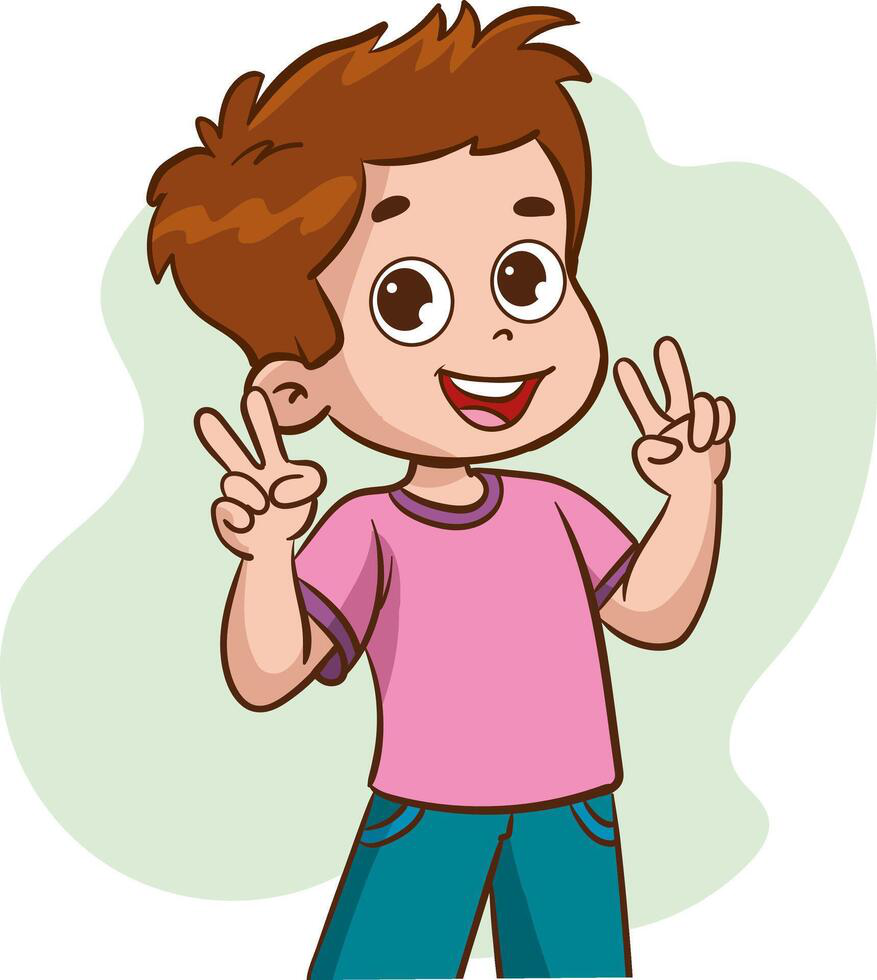

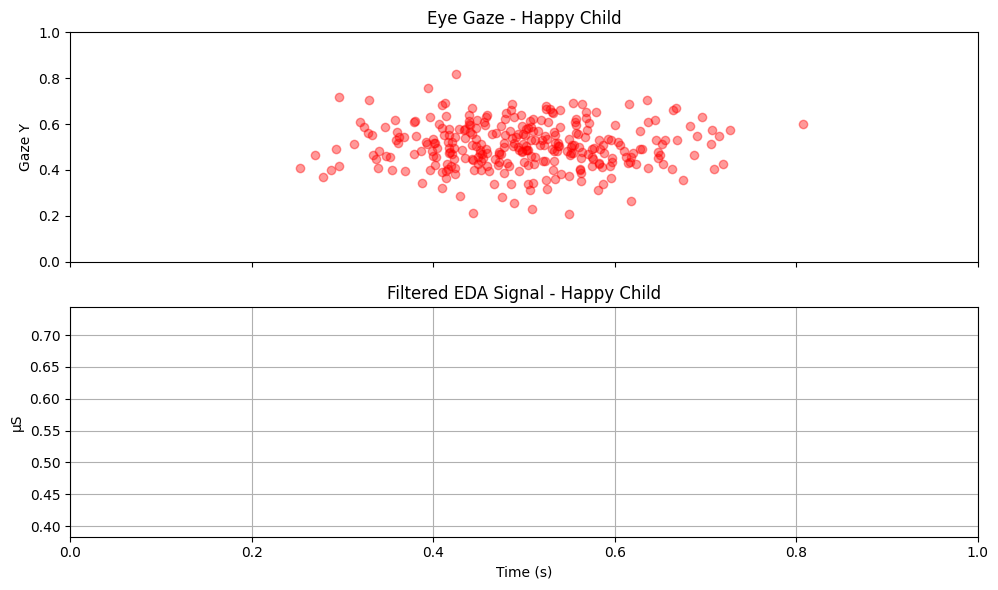

Stimulus: Angry Dog (10s to 15s)


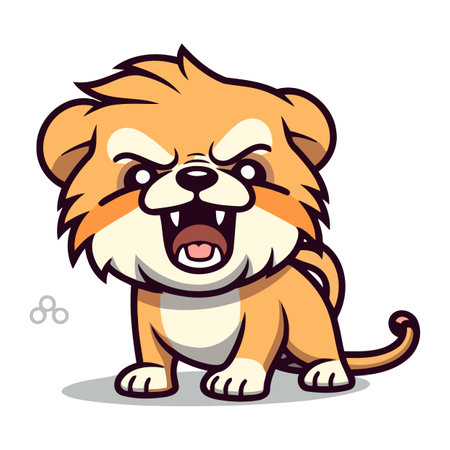

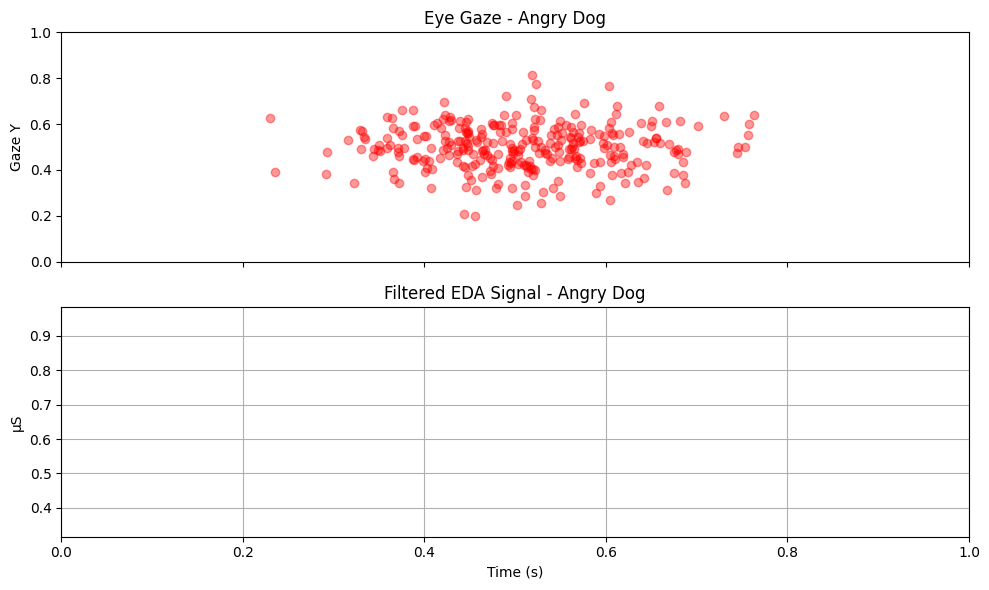

Stimulus: Neutral Scene (15s to 20s)


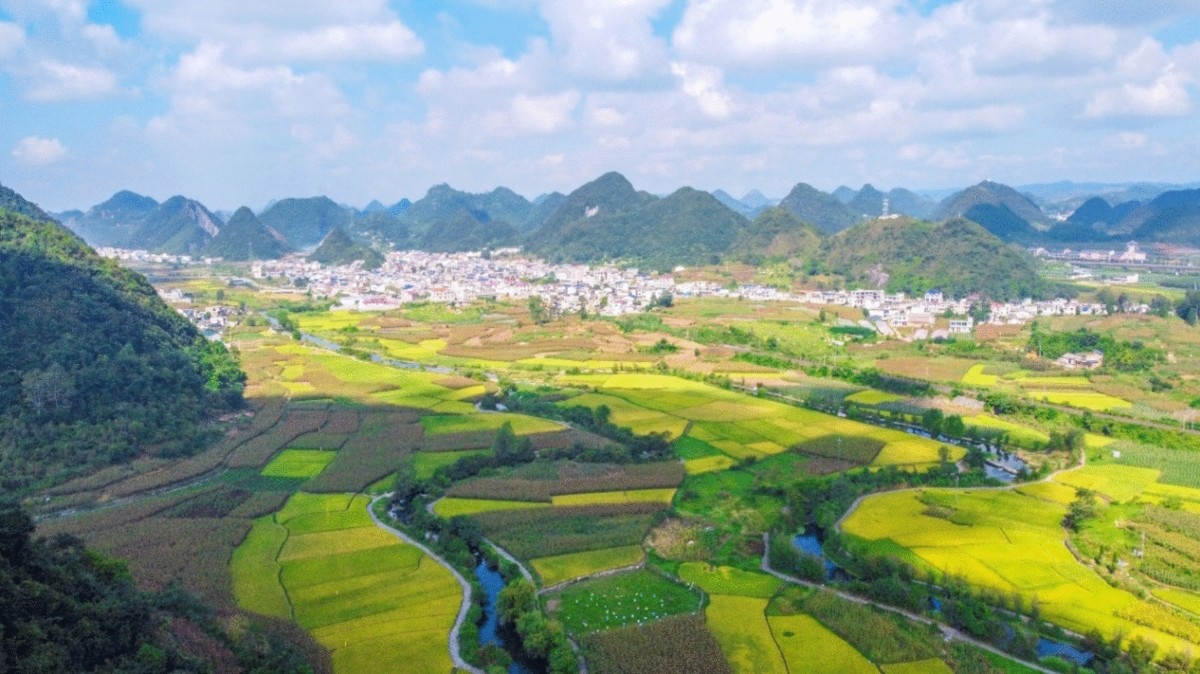

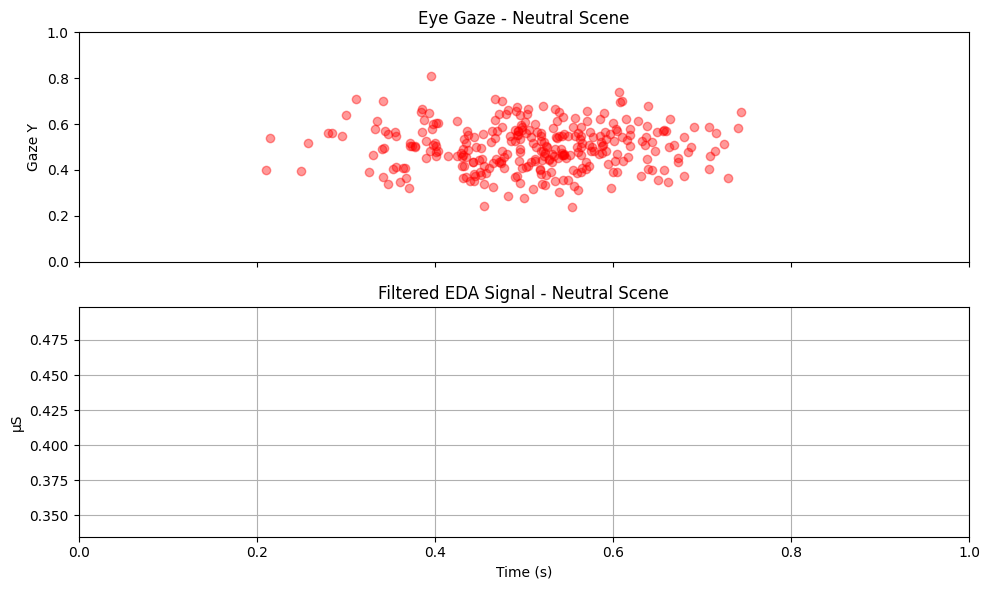

In [12]:

for label, start, end, eye_seg, eda_seg, img_path in segments:
    print(f"Stimulus: {label} ({start}s to {end}s)")
    try:
        display.display(Image.open(img_path))
    except:
        print(f"Image not found: {img_path}")

    fig, axs = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
    
    # Eye Tracking Plot
    axs[0].scatter(eye_seg["gaze_x"], eye_seg["gaze_y"], alpha=0.4, c='red')
    axs[0].invert_yaxis()
    axs[0].set_xlim(0, 1)
    axs[0].set_ylim(0, 1)
    axs[0].set_title(f"Eye Gaze - {label}")
    axs[0].set_ylabel("Gaze Y")

    # EDA Signal Plot
    axs[1].plot(eda_seg["timestamp_sec"], eda_seg["filtered_eda"], color='blue')
    axs[1].set_title(f"Filtered EDA Signal - {label}")
    axs[1].set_xlabel("Time (s)")
    axs[1].set_ylabel("µS")
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()


# Step 5: Observations


- **Happy Child**: Moderate arousal visible (~0.4 µS peak)  
- **Angry Dog**: Strong arousal (~0.6 µS), most emotionally intense  
- **Neutral Scene**: Low arousal (~0.2 µS), less variation  
- Eye gaze helps validate focus zones, EDA helps confirm emotional activation.


In [ ]:
#Step 6: Zoomed EDA Signal with Detected SCR Peaks
This section focuses on highlighting small SCR peaks in EDA signal. The peaks are real but occur in microSiemens range, so we zoom into the Y-axis and detect peaks automatically.


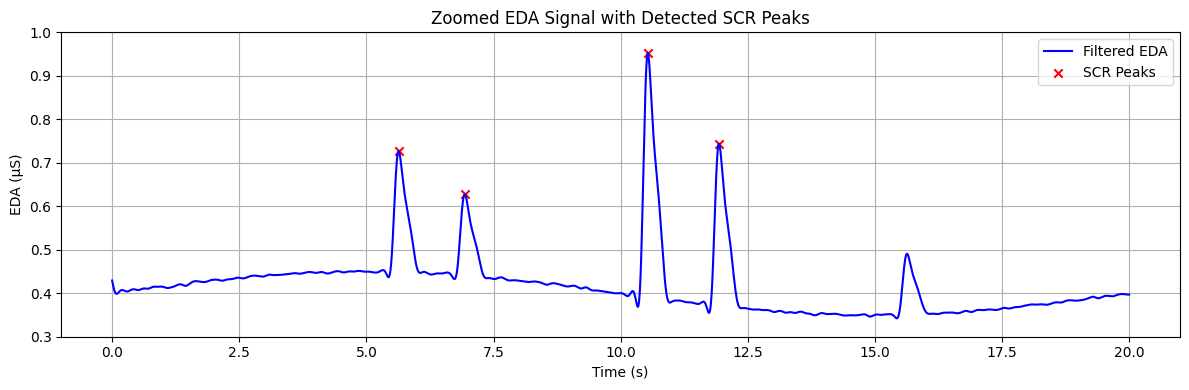

In [21]:
from scipy.signal import find_peaks

# Detecting peaks with minimum height threshold
peaks, properties = find_peaks(eda_df["filtered_eda"], height=0.5)

# Plot with zoom
plt.figure(figsize=(12, 4))
plt.plot(eda_df["timestamp_sec"], eda_df["filtered_eda"], label="Filtered EDA", color='blue')
plt.scatter(eda_df["timestamp_sec"].iloc[peaks], eda_df["filtered_eda"].iloc[peaks], color='red', marker='x', label="SCR Peaks")
plt.title("Zoomed EDA Signal with Detected SCR Peaks")
plt.xlabel("Time (s)")
plt.ylabel("EDA (µS)")
plt.ylim(0.3, 1.0)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



## Step 7: Combined Gaze and EDA Signal Visualization

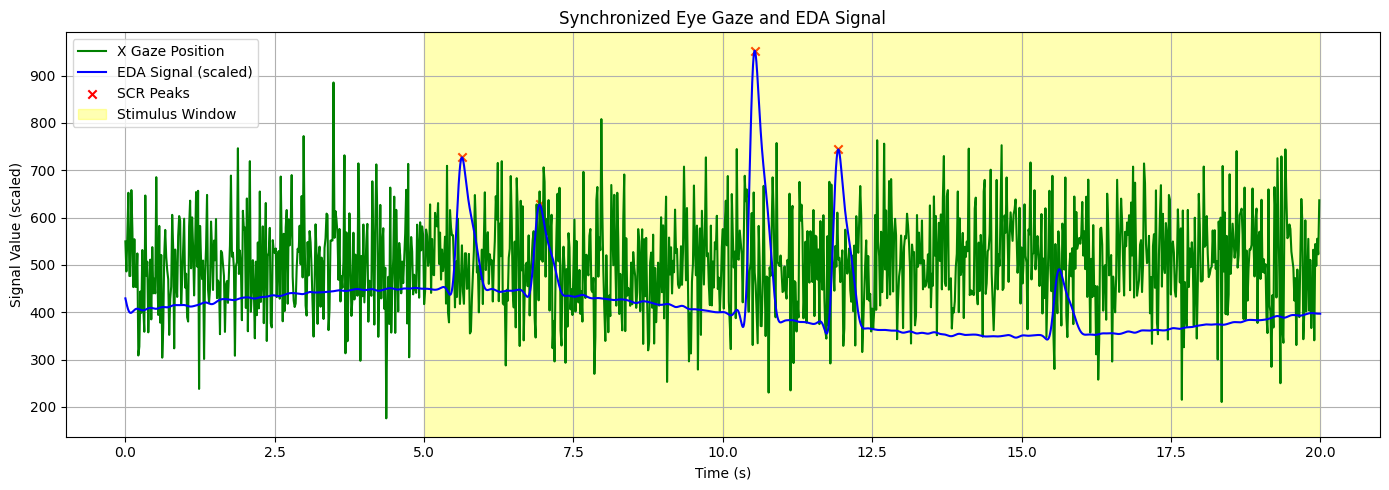

In [14]:

# Scaleing gaze and EDA for combined display
gaze_scaled = eye_df["gaze_x"] * 1000
eda_scaled = eda_df["filtered_eda"] * 1000

# Detect SCR peaks again
from scipy.signal import find_peaks
peaks, _ = find_peaks(eda_df["filtered_eda"], height=0.5)

# Plot
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(eye_df["timestamp_sec"], gaze_scaled, label="X Gaze Position", color='green')
ax.plot(eda_df["timestamp_sec"], eda_scaled, label="EDA Signal (scaled)", color='blue')

# Add SCR peaks
ax.scatter(eda_df["timestamp_sec"].iloc[peaks], eda_scaled[peaks], color='red', marker='x', label="SCR Peaks")

# Stimulus windows (manually added)
stimuli_windows = [(5, 10), (10, 15), (15, 20)]
for i, (start, end) in enumerate(stimuli_windows):
    ax.axvspan(start, end, color='yellow', alpha=0.3, label="Stimulus Window" if i == 0 else None)

ax.set_title("Synchronized Eye Gaze and EDA Signal")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Signal Value (scaled)")
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()
